# Pipe3: 
## To classify location of damage - front, rear or side.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [6]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2,l1
from keras.models import Sequential, load_model,Model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
import tensorflow as tf
from keras.layers import Input
from tensorflow.keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [7]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = VGG16(include_top=False, weights='imagenet')
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size= batch_size,
                                            class_mode=None, 
                                            shuffle=False) 
    bottleneck_features_train = model.predict(generator, nb_train_samples)
    np.save(location+'/bottleneck_features_train.npy', bottleneck_features_train)
    
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict(generator, nb_validation_samples)
    np.save(location+'/bottleneck_features_validation.npy', bottleneck_features_validation)

In [8]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print('epoch:', best_epoch+1, \
    ', val_accuracy:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

In [9]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
           
    print("Best Model:") 
    print_best_model_results(hist)

In [55]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True);

## Defining Inputs

In [11]:
# path to the model weights file
location = '/content/drive/MyDrive/NNDL/Datasets/case_study/data2a'
top_model_weights_path=location+'/top_model_weights' # will be saved into when we create our model
fine_tuned_model_path = location+'/ft_model.hdf5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50
batch_size = 8

In [12]:
# do not rerun!!
#save_bottleneck_features(location)

58900480/58889256 [==============================] - 0s 0us/step
Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [12]:
# load saved data and train a small, fully-connected model
def train_categorical_model1():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) 
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_1.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_1.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [13]:
d1_model, d1_history = train_categorical_model1()

Epoch 1/50
117/123 [===========================>..] - ETA: 0s - loss: 2.5007 - accuracy: 0.4861
Epoch 1: val_accuracy improved from -inf to 0.30994, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_1.hdf5
123/123 [==============================] - 3s 5ms/step - loss: 2.4426 - accuracy: 0.4923 - val_loss: 5.5205 - val_accuracy: 0.3099
Epoch 2/50
111/123 [==========================>...] - ETA: 0s - loss: 1.1314 - accuracy: 0.7117
Epoch 2: val_accuracy improved from 0.30994 to 0.54971, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_1.hdf5
123/123 [==============================] - 0s 4ms/step - loss: 1.1511 - accuracy: 0.7120 - val_loss: 2.8081 - val_accuracy: 0.5497
Epoch 3/50
111/123 [==========================>...] - ETA: 0s - loss: 0.7952 - accuracy: 0.7894
Epoch 3: val_accuracy improved from 0.54971 to 0.60819, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_1.hd

Best Model:
epoch: 7 , val_accuracy: 0.7309941649436951 , val_loss: 1.4471192359924316


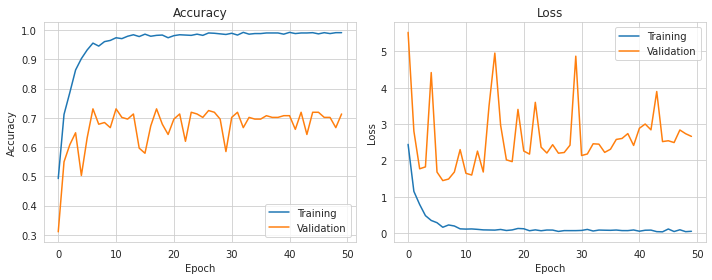

In [14]:
plot_metrics(d1_history) #rmsprop with no regularization,without dropout

In [15]:
# load saved data and train a small, fully-connected model
def train_categorical_model2():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))


    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_2.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_2.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [16]:
d2_model, d2_history = train_categorical_model2()

Epoch 1/50
116/123 [===========================>..] - ETA: 0s - loss: 3.9757 - accuracy: 0.4526
Epoch 1: val_accuracy improved from -inf to 0.53216, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_2.hdf5
123/123 [==============================] - 2s 8ms/step - loss: 3.8275 - accuracy: 0.4545 - val_loss: 0.9394 - val_accuracy: 0.5322
Epoch 2/50
118/123 [===========================>..] - ETA: 0s - loss: 1.2498 - accuracy: 0.5360
Epoch 2: val_accuracy improved from 0.53216 to 0.67836, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_2.hdf5
123/123 [==============================] - 1s 7ms/step - loss: 1.2398 - accuracy: 0.5393 - val_loss: 0.8855 - val_accuracy: 0.6784
Epoch 3/50
117/123 [===========================>..] - ETA: 0s - loss: 0.9799 - accuracy: 0.5887
Epoch 3: val_accuracy did not improve from 0.67836
123/123 [==============================] - 1s 6ms/step - loss: 0.9825 - accuracy: 0.5884 - val_los

Best Model:
epoch: 12 , val_accuracy: 0.7485380172729492 , val_loss: 1.0736703872680664


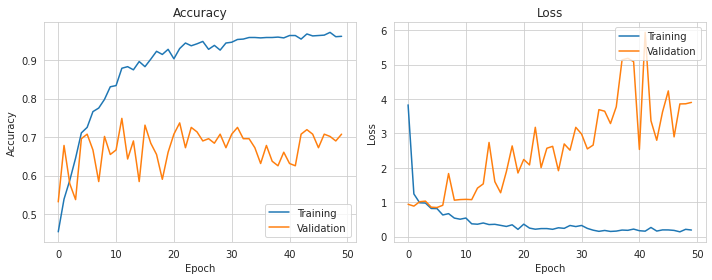

In [17]:
plot_metrics(d2_history) #rmsprop with dropout

In [18]:
# load saved data and train a small, fully-connected model
def train_categorical_model3():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_3.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_3.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [19]:
d3_model, d3_history = train_categorical_model3()

Epoch 1/50
121/123 [============================>.] - ETA: 0s - loss: 4.6621 - accuracy: 0.4380
Epoch 1: val_accuracy improved from -inf to 0.49708, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_3.hdf5
123/123 [==============================] - 2s 10ms/step - loss: 4.6260 - accuracy: 0.4382 - val_loss: 2.2936 - val_accuracy: 0.4971
Epoch 2/50
120/123 [============================>.] - ETA: 0s - loss: 2.6572 - accuracy: 0.4000
Epoch 2: val_accuracy did not improve from 0.49708
123/123 [==============================] - 1s 8ms/step - loss: 2.6315 - accuracy: 0.4045 - val_loss: 1.4145 - val_accuracy: 0.4912
Epoch 3/50
120/123 [============================>.] - ETA: 0s - loss: 1.9745 - accuracy: 0.4198
Epoch 3: val_accuracy did not improve from 0.49708
123/123 [==============================] - 1s 8ms/step - loss: 1.9617 - accuracy: 0.4188 - val_loss: 2.2383 - val_accuracy: 0.4327
Epoch 4/50
120/123 [============================>.] - ETA: 0s - los

Best Model:
epoch: 10 , val_accuracy: 0.6549707651138306 , val_loss: 1.2176198959350586


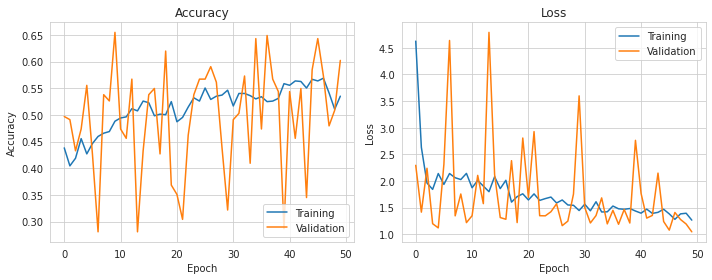

In [20]:
plot_metrics(d3_history) #rmsprop with dropout and regularization

In [21]:
# load saved data and train a small, fully-connected model
def train_categorical_model4():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_4.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_4.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [22]:
d4_model, d4_history = train_categorical_model4()

Epoch 1/50
123/123 [==============================] - ETA: 0s - loss: 4.5471 - accuracy: 0.3636
Epoch 1: val_accuracy improved from -inf to 0.43275, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_4.hdf5
123/123 [==============================] - 2s 10ms/step - loss: 4.5471 - accuracy: 0.3636 - val_loss: 1.1691 - val_accuracy: 0.4327
Epoch 2/50
118/123 [===========================>..] - ETA: 0s - loss: 3.4622 - accuracy: 0.3718
Epoch 2: val_accuracy did not improve from 0.43275
123/123 [==============================] - 1s 8ms/step - loss: 3.3950 - accuracy: 0.3769 - val_loss: 1.9730 - val_accuracy: 0.2924
Epoch 3/50
120/123 [============================>.] - ETA: 0s - loss: 2.0836 - accuracy: 0.3927
Epoch 3: val_accuracy did not improve from 0.43275
123/123 [==============================] - 1s 8ms/step - loss: 2.0843 - accuracy: 0.3933 - val_loss: 2.3739 - val_accuracy: 0.2807
Epoch 4/50
119/123 [============================>.] - ETA: 0s - los

Best Model:
epoch: 28 , val_accuracy: 0.567251443862915 , val_loss: 1.1329783201217651


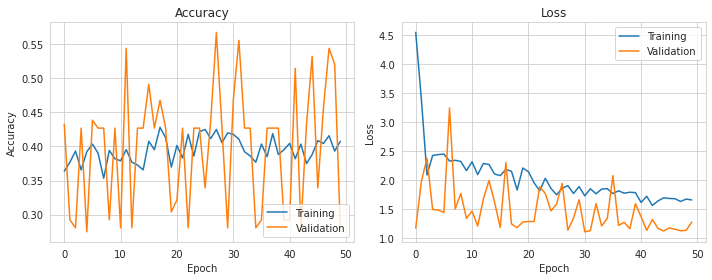

In [23]:
plot_metrics(d4_history) #rmsprop with aggresive dropout and regularization

In [24]:
# load saved data and train a small, fully-connected model
def train_categorical_model5():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_5.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_5.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [25]:
d5_model, d5_history = train_categorical_model5()

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


123/123 [==============================] - ETA: 0s - loss: 6.2210 - accuracy: 0.4229
Epoch 1: val_accuracy improved from -inf to 0.39766, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_5.hdf5
123/123 [==============================] - 1s 8ms/step - loss: 6.2210 - accuracy: 0.4229 - val_loss: 6.1327 - val_accuracy: 0.3977
Epoch 2/50
120/123 [============================>.] - ETA: 0s - loss: 6.0845 - accuracy: 0.4646
Epoch 2: val_accuracy improved from 0.39766 to 0.50877, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_5.hdf5
123/123 [==============================] - 1s 7ms/step - loss: 6.0847 - accuracy: 0.4627 - val_loss: 6.0568 - val_accuracy: 0.5088
Epoch 3/50
121/123 [============================>.] - ETA: 0s - loss: 6.0134 - accuracy: 0.4969
Epoch 3: val_accuracy improved from 0.50877 to 0.54971, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_5.hdf5
123/123 

Best Model:
epoch: 41 , val_accuracy: 0.7251461744308472 , val_loss: 5.022159099578857


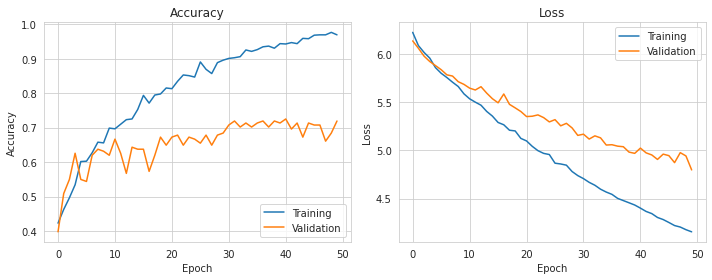

In [26]:
plot_metrics(d5_history) #sgd with dropout and regularization

In [27]:
# load saved data and train a small, fully-connected model
def train_categorical_model6():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_6.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_6.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [28]:
d6_model, d6_history = train_categorical_model6()

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


122/123 [============================>.] - ETA: 0s - loss: 1.7016 - accuracy: 0.4129
Epoch 1: val_accuracy improved from -inf to 0.45614, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_6.hdf5
123/123 [==============================] - 1s 8ms/step - loss: 1.7012 - accuracy: 0.4137 - val_loss: 1.5279 - val_accuracy: 0.4561
Epoch 2/50
118/123 [===========================>..] - ETA: 0s - loss: 1.5488 - accuracy: 0.4619
Epoch 2: val_accuracy improved from 0.45614 to 0.53801, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_6.hdf5
123/123 [==============================] - 1s 7ms/step - loss: 1.5496 - accuracy: 0.4617 - val_loss: 1.5259 - val_accuracy: 0.5380
Epoch 3/50
120/123 [============================>.] - ETA: 0s - loss: 1.4982 - accuracy: 0.5052
Epoch 3: val_accuracy did not improve from 0.53801
123/123 [==============================] - 1s 6ms/step - loss: 1.4988 - accuracy: 0.5036 - val_loss: 1.4817 -

Best Model:
epoch: 34 , val_accuracy: 0.7309941649436951 , val_loss: 1.2653168439865112


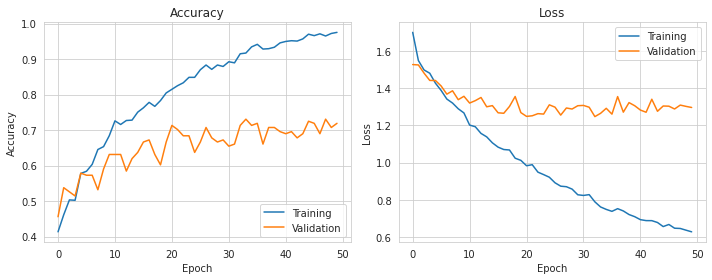

In [30]:
plot_metrics(d6_history) #sgd with dropout and aggresive regularization

In [31]:
# load saved data and train a small, fully-connected model
def train_categorical_model7():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_7.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_7.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [32]:
d7_model, d7_history = train_categorical_model7()

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


113/123 [==========================>...] - ETA: 0s - loss: 1.7803 - accuracy: 0.3827
Epoch 1: val_accuracy improved from -inf to 0.42105, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_7.hdf5
123/123 [==============================] - 1s 8ms/step - loss: 1.7685 - accuracy: 0.3851 - val_loss: 1.5612 - val_accuracy: 0.4211
Epoch 2/50
123/123 [==============================] - ETA: 0s - loss: 1.5826 - accuracy: 0.4065
Epoch 2: val_accuracy improved from 0.42105 to 0.46784, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_7.hdf5
123/123 [==============================] - 1s 6ms/step - loss: 1.5826 - accuracy: 0.4065 - val_loss: 1.5589 - val_accuracy: 0.4678
Epoch 3/50
123/123 [==============================] - ETA: 0s - loss: 1.5654 - accuracy: 0.4382
Epoch 3: val_accuracy did not improve from 0.46784
123/123 [==============================] - 1s 6ms/step - loss: 1.5654 - accuracy: 0.4382 - val_loss: 1.5327 -

Best Model:
epoch: 31 , val_accuracy: 0.7017543911933899 , val_loss: 1.3191938400268555


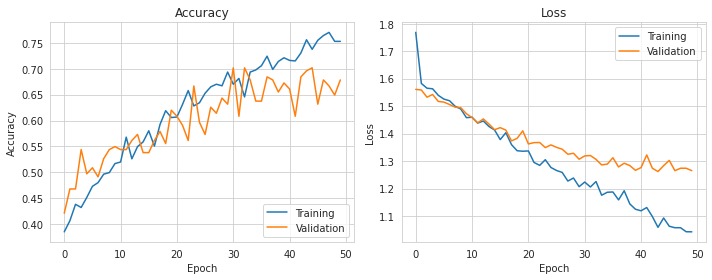

In [33]:
plot_metrics(d7_history) #sgd with dropout and aggresive regularization

In [34]:
# load saved data and train a small, fully-connected model
def train_categorical_model8():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dense(128, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_8.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_8.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [35]:
d8_model, d8_history = train_categorical_model8()

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


117/123 [===========================>..] - ETA: 0s - loss: 1.9254 - accuracy: 0.3761
Epoch 1: val_accuracy improved from -inf to 0.53801, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_8.hdf5
123/123 [==============================] - 1s 8ms/step - loss: 1.9201 - accuracy: 0.3769 - val_loss: 1.7478 - val_accuracy: 0.5380
Epoch 2/50
120/123 [============================>.] - ETA: 0s - loss: 1.7918 - accuracy: 0.4052
Epoch 2: val_accuracy improved from 0.53801 to 0.54971, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_8.hdf5
123/123 [==============================] - 1s 7ms/step - loss: 1.7930 - accuracy: 0.4035 - val_loss: 1.7247 - val_accuracy: 0.5497
Epoch 3/50
121/123 [============================>.] - ETA: 0s - loss: 1.7934 - accuracy: 0.3843
Epoch 3: val_accuracy did not improve from 0.54971
123/123 [==============================] - 1s 6ms/step - loss: 1.7925 - accuracy: 0.3841 - val_loss: 1.7284 -

Best Model:
epoch: 41 , val_accuracy: 0.719298243522644 , val_loss: 1.4674861431121826


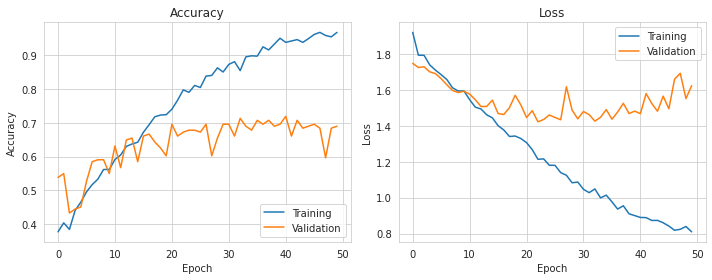

In [36]:
plot_metrics(d8_history) #sgd with dropout and aggresive regularization with additional dense layer

In [37]:
# load saved data and train a small, fully-connected model
def train_categorical_model9():
    # the features were saved in order, so recreating the labels is not hard
    train_data = np.load(location+'/bottleneck_features_train.npy')
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1] + 
                            [2] * train_samples[2])
    train_labels = to_categorical(train_labels)

    validation_data = np.load(location+'/bottleneck_features_validation.npy')
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1] +
                                 [2] * validation_samples[2])
    validation_labels = to_categorical(validation_labels)
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation = 'relu',kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.75))
    model.add(Dense(3, activation = 'softmax'))

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path+"_9.hdf5", monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, save_weights_only=True, mode='max')


    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=batch_size,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history_9.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [38]:
d9_model, d9_history = train_categorical_model9()

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


117/123 [===========================>..] - ETA: 0s - loss: 2.0805 - accuracy: 0.3579
Epoch 1: val_accuracy improved from -inf to 0.37427, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_9.hdf5
123/123 [==============================] - 2s 8ms/step - loss: 2.0663 - accuracy: 0.3647 - val_loss: 1.7719 - val_accuracy: 0.3743
Epoch 2/50
121/123 [============================>.] - ETA: 0s - loss: 1.7821 - accuracy: 0.3533
Epoch 2: val_accuracy improved from 0.37427 to 0.43860, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/top_model_weights_9.hdf5
123/123 [==============================] - 1s 7ms/step - loss: 1.7818 - accuracy: 0.3555 - val_loss: 1.7665 - val_accuracy: 0.4386
Epoch 3/50
117/123 [===========================>..] - ETA: 0s - loss: 1.7721 - accuracy: 0.4188
Epoch 3: val_accuracy did not improve from 0.43860
123/123 [==============================] - 1s 6ms/step - loss: 1.7727 - accuracy: 0.4106 - val_loss: 1.7719 -

Best Model:
epoch: 2 , val_accuracy: 0.4385964870452881 , val_loss: 1.7665337324142456


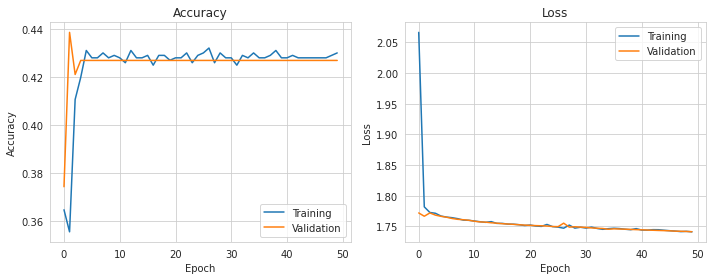

In [39]:
plot_metrics(d9_history) #sgd with dropout and aggresive regularization with additional dense layer

In [40]:
def finetune_categorical_model():
    # Build the VGG16 Network (again)
    input_tensor = Input(shape=(256,256,3))
    base_model = VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(3, activation='softmax'))

    top_model.load_weights(top_model_weights_path+"_2.hdf5")

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    
    for layer in model.layers[:25]:
        layer.trainable=False


    model.compile(loss='categorical_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9),
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='categorical')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='categorical')
    
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=2, save_best_only=True, 
                                 save_weights_only=False, mode='max')
    # fine-tune the model
    fit = model.fit(train_generator,
                    steps_per_epoch=nb_train_samples//batch_size,
                        epochs=nb_epoch,
                        validation_data=validation_generator,
                         validation_steps=nb_validation_samples//batch_size,
                        verbose=1,
                        callbacks=[checkpoint])
    
    with open(location+'/history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [41]:
ft_model, ft_history = finetune_categorical_model()

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.
Epoch 1/50
122/122 [==============================] - ETA: 0s - loss: 16.8618 - accuracy: 0.6138
Epoch 1: val_accuracy improved from -inf to 0.74405, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/ft_model.hdf5
122/122 [==============================] - 316s 3s/step - loss: 16.8618 - accuracy: 0.6138 - val_loss: 16.6851 - val_accuracy: 0.7440
Epoch 2/50
122/122 [==============================] - ETA: 0s - loss: 16.9540 - accuracy: 0.5675
Epoch 2: val_accuracy improved from 0.74405 to 0.75000, saving model to /content/drive/MyDrive/NNDL/Datasets/case_study/data2a/ft_model.hdf5
122/122 [==============================] - 20s 164ms/step - loss: 16.9540 - accuracy: 0.5675 - val_loss: 16.6442 - val_accuracy: 0.7500
Epoch 3/50
122/122 [==============================] - ETA: 0s - loss: 16.9442 - accuracy: 0.5798
Epoch 3: val_accuracy did not improve from 0.75000
122/122 [==================

Best Model:
epoch: 5 , val_accuracy: 0.761904776096344 , val_loss: 16.594295501708984


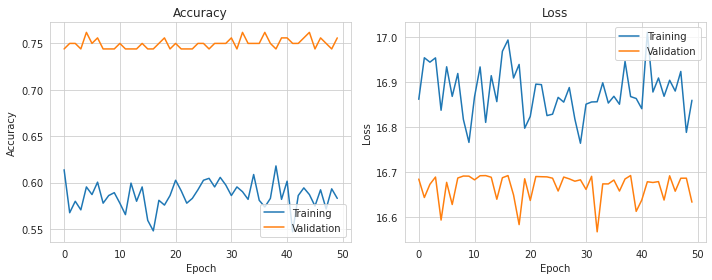

In [42]:
plot_metrics(ft_history)

##Load Model Point

In [43]:
ft_model = load_model(location+'/ft_model.hdf5')

In [44]:
with open(location+'/top_history_2.txt') as f:    
    top_history = json.load(f)

In [46]:
with open(location+'/history.txt') as f:    
    ft_history = json.load(f)

In [47]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print("Best Model:") 
    print_best_model_results(hist)

In [48]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [63]:
def evaluate_categorical_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=batch_size,
                                class_mode='categorical',
                                shuffle=False)
    
    predictions = model.predict(generator, len(labels))
    pred_labels = np.argmax(predictions, axis=1)
    
    print('')
    print(classification_report(validation_labels, pred_labels))
    print('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm

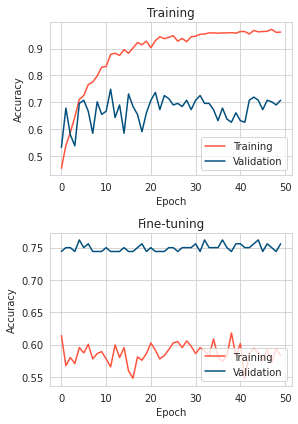

In [50]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 5 , val_accuracy: 0.761904776096344 , val_loss: 16.594295501708984


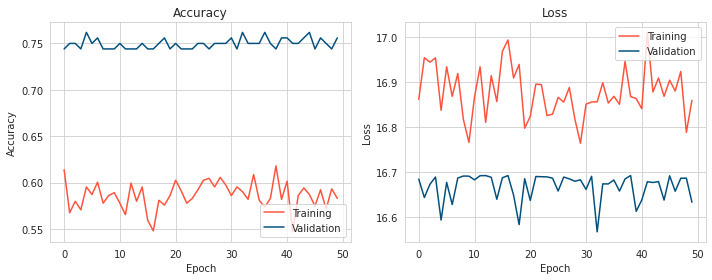

In [51]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [53]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1]+
                             [2] * validation_samples[2])

In [64]:
cm = evaluate_categorical_model(ft_model, validation_data_dir, validation_labels)

Found 171 images belonging to 3 classes.

              precision    recall  f1-score   support

           0       0.71      0.89      0.79        73
           1       0.82      0.64      0.72        50
           2       0.76      0.65      0.70        48

    accuracy                           0.75       171
   macro avg       0.76      0.73      0.74       171
weighted avg       0.76      0.75      0.74       171




In [60]:
heatmap_labels = ['Front', 'Rear', 'Side']

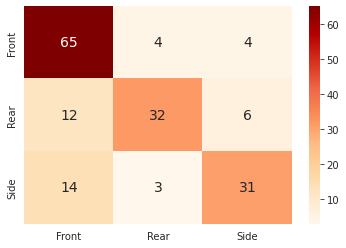

In [65]:
sns.heatmap(cm, annot=True, annot_kws={"size": 14}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [97]:
from urllib.request import urlretrieve

def car_categories_gate(image_path, model,option=1):
    if(option==1):
      urlretrieve(image_path, 'save.jpg')
      img = load_img('save.jpg', target_size=(256, 256))
    else:
      img = load_img(image_path, target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    pred = model.predict(x)
    print(pred)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'Front', 1:'Rear', 2:'Side'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("Validating location of damage....Result:",d[key])
    print("Severity assessment complete.")

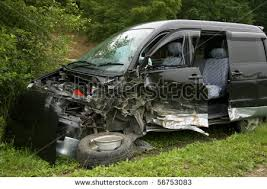

In [98]:
Image(location+"/validation/00-front/0001.JPEG")

In [99]:
car_categories_gate(location+"/validation/00-front/0001.JPEG", ft_model,0)

[[9.7958517e-01 2.0301446e-02 1.1337385e-04]]
Validating location of damage....Result: Front
Severity assessment complete.


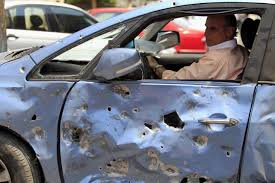

In [100]:
Image('/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation/00-damage/0010.JPEG')

In [101]:
car_categories_gate('/content/drive/MyDrive/NNDL/Datasets/case_study/data1a/validation/00-damage/0010.JPEG', ft_model,0)

[[3.6739260e-05 8.9557767e-07 9.9996233e-01]]
Validating location of damage....Result: Side
Severity assessment complete.


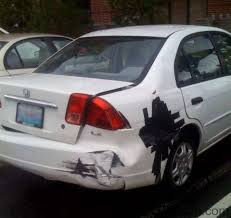

In [102]:
Image(location+"/validation/01-rear/0002.JPEG")

In [103]:
car_categories_gate(location+"/validation/01-rear/0002.JPEG", ft_model,0)

[[0.15455368 0.83227485 0.01317146]]
Validating location of damage....Result: Rear
Severity assessment complete.


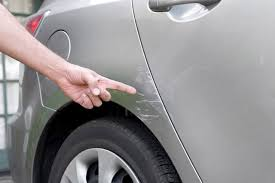

In [104]:
Image(location+"/validation/02-side/0004.JPEG")

In [105]:
car_categories_gate(location+"/validation/02-side/0004.JPEG", ft_model,0)

[[1.1781391e-03 5.5692867e-06 9.9881637e-01]]
Validating location of damage....Result: Side
Severity assessment complete.


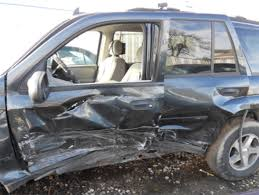

In [106]:
Image(location+"/validation/02-side/0005.JPEG")

In [107]:
car_categories_gate(location+"/validation/02-side/0005.JPEG", ft_model,0)

[[0.02776048 0.01272014 0.9595194 ]]
Validating location of damage....Result: Side
Severity assessment complete.


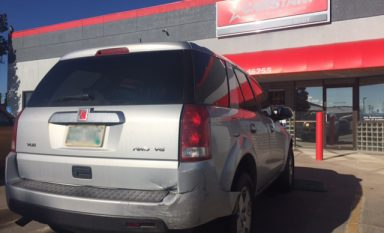

In [108]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [109]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

[[1.3084677e-03 9.9841177e-01 2.7971258e-04]]
Validating location of damage....Result: Rear
Severity assessment complete.
